<a href="https://colab.research.google.com/github/kashperova/iasa-nlp-course/blob/main/assigment_5/bert_commonlit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 39.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 72.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 53.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 27.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import nltk
import string
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split, GridSearchCV
import pickle
import torch
from torch.utils.data import Dataset
import torch.nn as nn
from torch.nn.functional import mse_loss
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from torch.utils.data import DataLoader
import torch.nn.functional as F
from transformers import BertModel, BertTokenizer
import optuna

In [3]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Transformers

### Wording features description
- <b>wording</b> - target summary score
- <b>prompt_id</b> - id of prompt to summarize
- <b>text</b> - preprocessed joined text of student's summary, prompt text, prompt title
- <b>cite</b> - whether is proposed in prompt question to cite evidence from the text.
- <b>mistakes</b> - amount of spelling correction
- <b>n_sentences</b> - amount of sentences in summary
- <b>unique_word_count</b> - amount of unique words in student's summary
- <b>adj_adv_count</b> - amount of adjectives and adverbs in student's summary
- <b>fk_score</b> - Flesch-Kincaid readability score in student's summary

### Content features description
- <b>content</b> - target summary score
- <b>prompt_id</b> - id of prompt to summarize
- <b>text</b> - preprocessed joined text of student's summary, prompt text, prompt title
- <b>mistakes</b> - amount of spelling correction
- <b>n_sentences</b> - amount of sentences in summary
- <b>punctuation_count</b> - amount of punctuation in student's summary
- <b>unique_word_count</b> - amount of unique words in student's summary
- <b>adj_adv_count</b> - amount of adjectives and adverbs in student's summary

In [7]:
content_dfrm = pd.read_csv("content_train.csv")
content_dfrm.head()

,content,mistakes,n_sentences,punctuation_count,unique_word_count,adj_adv_count,prompt_id,text
0,0.205683,3,4,3,50,9,814d6b,the third wave was an experimentto see how peo...
1,-0.548304,1,3,2,36,6,ebad26,they would rub it up with soda to make the sme...
2,3.128928,9,13,38,142,25,3b9047,"in egypt, there were many occupations and soci..."
3,-0.210614,4,5,6,21,3,3b9047,the highest class was pharaohs these people we...
4,3.272894,23,14,30,133,18,814d6b,the third wave developed rapidly because the ...


In [8]:
wording_dfrm =  pd.read_csv("wording_train.csv")
wording_dfrm.head()

,wording,cite,mistakes,n_sentences,punctuation_count,unique_word_count,adj_adv_count,fk_score,prompt_id,text
0,0.380538,0,3,4,3,50,9,8.1,814d6b,the third wave was an experimentto see how peo...
1,0.506755,1,1,3,2,36,6,7.5,ebad26,they would rub it up with soda to make the sme...
2,4.231226,1,9,13,38,142,25,8.5,3b9047,"in egypt, there were many occupations and soci..."
3,-0.471415,1,4,5,6,21,3,5.3,3b9047,the highest class was pharaohs these people we...
4,3.219757,0,23,14,30,133,18,7.8,814d6b,the third wave developed rapidly because the ...


In [9]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

## Custom dataset for Content

In [ ]:
class ContentDataset(Dataset):
    def __init__(self, dfrm):
        self.dfrm = dfrm

    def __len__(self):
        return len(self.dfrm)

    def __getitem__(self, idx):
        text = self.dfrm.iloc[idx]['text']
        inputs = tokenizer.encode_plus(text.lower(),
                                            truncation=True,
                                            padding='max_length',
                                            max_length=512,
                                            return_attention_mask=True,
                                            return_tensors = 'pt')

        input_ids = inputs['input_ids'].flatten()
        attention_mask = inputs['attention_mask'].flatten()
        token_type_ids = inputs['token_type_ids'].flatten()

        features = list(self.dfrm.iloc[idx][['mistakes', 'n_sentences', 'punctuation_count', 'unique_word_count', 'adj_adv_count']].values)

        return input_ids, attention_mask, token_type_ids, torch.FloatTensor(features), torch.FloatTensor([self.dfrm.iloc[idx]['content']])

## Custom dataset for Wording

In [10]:
class WordingDataset(Dataset):
    def __init__(self, dfrm):
        self.dfrm = dfrm

    def __len__(self):
        return len(self.dfrm)

    def __getitem__(self, idx):
        text = self.dfrm.iloc[idx]['text']
        inputs = tokenizer.encode_plus(text.lower(),
                                            truncation=True,
                                            padding='max_length',
                                            max_length=512,
                                            return_attention_mask=True,
                                            return_tensors = 'pt')

        input_ids = inputs['input_ids'].flatten()
        attention_mask = inputs['attention_mask'].flatten()
        token_type_ids = inputs['token_type_ids'].flatten()

        features = list(self.dfrm.iloc[idx][['cite', 'mistakes', 'n_sentences', 'punctuation_count', 'unique_word_count', 'adj_adv_count', 'fk_score']].values)

        return input_ids, attention_mask, token_type_ids, torch.FloatTensor(features), torch.FloatTensor([self.dfrm.iloc[idx]['wording']])

## Modeling

I decided to create simple custom class for BERT. The difference between content and wording models only in size of input features for dense layer.

In [ ]:
class ContentBERT(nn.Module):
    def __init__(self, dropout):
        super(ContentBERT, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(768 + 5, 1)

    def forward(self,  input_ids, attention_mask, token_type_ids, x_features):
        bert_output = self.bert(input_ids=input_ids,
                                 attention_mask = attention_mask,
                                 token_type_ids = token_type_ids)
        pooled_output = bert_output.pooler_output
        pooled_output = self.dropout(pooled_output)


        combined = torch.cat([pooled_output, x_features], dim=1)
        return self.fc(combined)

In [11]:
class WordingBERT(nn.Module):
    def __init__(self, dropout):
        super(WordingBERT, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.fc = nn.Linear(768 + 7, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_ids, attention_mask, token_type_ids, x_features):
        bert_output = self.bert(input_ids=input_ids,
                                 attention_mask = attention_mask,
                                 token_type_ids = token_type_ids)
        pooled_output = bert_output.pooler_output
        pooled_output = self.dropout(pooled_output)

        combined = torch.cat([pooled_output, x_features], dim=1)
        return self.fc(combined)

Train and validation loops (return rmse as metric)

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
def train(model, dataloader, criterion, optimizer):
    model.train()
    total_loss = 0.0
    for input_ids, attention_mask, token_type_ids, x_features, y in dataloader:
        optimizer.zero_grad()
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        token_type_ids = token_type_ids.to(device)
        x_features = x_features.to(device)
        outputs = model(input_ids, attention_mask, token_type_ids, x_features)
        y = y.float()
        y = y.to(device)
        outputs = outputs.to(device)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        total_loss += mse_loss(outputs, y).item()
    return (total_loss / len(dataloader)) ** 0.5

def validate(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for input_ids, attention_mask, token_type_ids, x_features, y in dataloader:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            x_features = x_features.to(device)
            outputs = model(input_ids, attention_mask, token_type_ids, x_features)
            y = y.float()
            y = y.to(device)
            outputs = outputs.to(device)
            loss = criterion(outputs, y)
            total_loss += mse_loss(outputs, y).item()
    return (total_loss / len(dataloader)) ** 0.5

## Training

### Content

In [ ]:
train_losses_content, val_losses_content = [], []

In [ ]:
def train_content(dropout: int, lr: int, batch_size: int):
    aggregated_val_loss = 0.0
    folds = 0

    n_splits = 4
    group_kfold = GroupKFold(n_splits=n_splits)

    for train_idx, val_idx in group_kfold.split(content_dfrm, content_dfrm['content'], content_dfrm['prompt_id']):
        folds += 1
        print(f"Fold: {folds}\n")
        train_data, val_data = content_dfrm.iloc[train_idx], content_dfrm.iloc[val_idx]

        train_dataset = ContentDataset(train_data)
        val_dataset = ContentDataset(val_data)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)

        model = ContentBERT(dropout=dropout).to(device)
        criterion = nn.MSELoss()
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

        best_val_loss = float('inf')
        epochs = 5
        for epoch in range(epochs):
            train_loss = train(model, train_loader, criterion, optimizer)
            val_loss = validate(model, val_loader, criterion)

            print(f"Epoch {epoch+1}/{epochs} - Train RMSE: {train_loss:.4f}, Val RMSE: {val_loss:.4f}")

            train_losses_content.append(train_loss)
            val_losses_content.append(val_loss)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), 'content_bert.pt')

        aggregated_val_loss += best_val_loss

    return aggregated_val_loss / n_splits

Use optuna to optimize hyperparameters

In [ ]:
# def objective(trial):
#     lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
#     dropout = trial.suggest_float("dropout", 0.2, 0.5)
#     batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
#     return train_wording(dropout, lr, batch_size)

# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=10)

# best_params = study.best_params

In [ ]:
train_content(dropout=0.29928979789778737, lr=0.00023899150738147665, batch_size=32)

Fold: 1



Epoch 1/5 - Train RMSE: 1.5181, Val RMSE: 0.9544
Epoch 2/5 - Train RMSE: 0.8188, Val RMSE: 0.6584
Epoch 3/5 - Train RMSE: 0.7024, Val RMSE: 0.6143
Epoch 4/5 - Train RMSE: 0.6878, Val RMSE: 0.5856
Epoch 5/5 - Train RMSE: 0.6802, Val RMSE: 0.6170
Fold: 2

Epoch 1/5 - Train RMSE: 0.8308, Val RMSE: 0.6705
Epoch 2/5 - Train RMSE: 0.6544, Val RMSE: 0.7080
Epoch 3/5 - Train RMSE: 0.6428, Val RMSE: 0.8571
Epoch 4/5 - Train RMSE: 0.6272, Val RMSE: 0.7226
Epoch 5/5 - Train RMSE: 0.6154, Val RMSE: 0.7679
Fold: 3

Epoch 1/5 - Train RMSE: 0.8014, Val RMSE: 0.6399
Epoch 2/5 - Train RMSE: 0.6632, Val RMSE: 0.6310
Epoch 3/5 - Train RMSE: 0.6543, Val RMSE: 0.6386
Epoch 4/5 - Train RMSE: 0.6393, Val RMSE: 0.6453
Epoch 5/5 - Train RMSE: 0.6328, Val RMSE: 0.6277
Fold: 4

Epoch 1/5 - Train RMSE: 1.2287, Val RMSE: 1.1004
Epoch 2/5 - Train RMSE: 0.7680, Val RMSE: 0.9195
Epoch 3/5 - Train RMSE: 0.7101, Val RMSE: 0.8067
Epoch 4/5 - Train RMSE: 0.6937, Val RMSE: 0.8276
Epoch 5/5 - Train RMSE: 0.6796, Val RMSE: 

0.6726400488475555

Plotting the losses and metrics

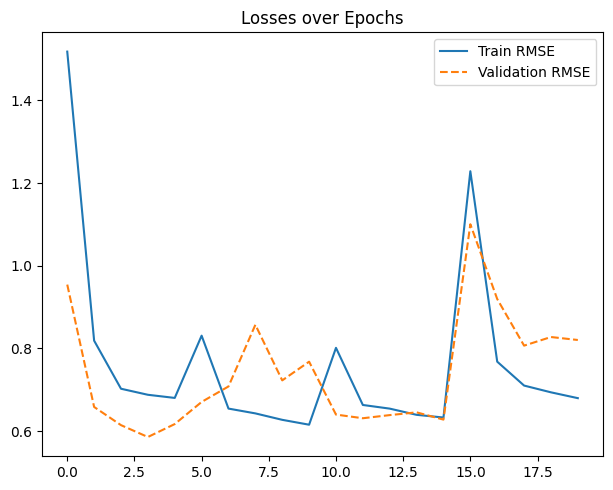

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses_content, label="Train RMSE")
plt.plot(val_losses_content, label="Validation RMSE", linestyle='--')
plt.legend()
plt.title("Losses over Epochs")

plt.tight_layout()
plt.show()

Save the best model state_dict

### Wording

In [14]:
train_losses_wording, val_losses_wording = [], []

In [17]:
def train_wording(dropout: int, lr: int, batch_size: int):
    aggregated_val_loss = 0.0
    folds = 0

    n_splits = 4
    group_kfold = GroupKFold(n_splits=n_splits)

    for train_idx, val_idx in group_kfold.split(wording_dfrm, wording_dfrm['wording'], wording_dfrm['prompt_id']):
        folds += 1
        print(f"Fold: {folds}\n")
        train_data, val_data = wording_dfrm.iloc[train_idx], wording_dfrm.iloc[val_idx]

        train_dataset = WordingDataset(train_data)
        val_dataset = WordingDataset(val_data)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)

        model = WordingBERT(dropout=dropout).to(device)
        criterion = nn.MSELoss()
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

        best_val_loss = float('inf')
        epochs = 5
        for epoch in range(epochs):
            train_loss = train(model, train_loader, criterion, optimizer)
            val_loss = validate(model, val_loader, criterion)

            print(f"Epoch {epoch+1}/{epochs} - Train RMSE: {train_loss:.4f}, Val RMSE: {val_loss:.4f}")

            train_losses_wording.append(train_loss)
            val_losses_wording.append(val_loss)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), 'wording_bert.pt')

        aggregated_val_loss += best_val_loss

    return aggregated_val_loss / n_splits

In [ ]:
# def objective(trial):
#     lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
#     dropout = trial.suggest_float("dropout", 0.2, 0.5)
#     batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
#     return train_wording(dropout, lr, batch_size)

# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=10)

# best_params = study.best_params

In [18]:
train_wording(dropout=0.28928979689778737, lr=0.000158699150738247763, batch_size=16)

Fold: 1

Epoch 1/5 - Train RMSE: 1.0880, Val RMSE: 0.9150
Epoch 2/5 - Train RMSE: 0.9680, Val RMSE: 0.9004
Epoch 3/5 - Train RMSE: 0.9299, Val RMSE: 0.8617
Epoch 4/5 - Train RMSE: 0.9100, Val RMSE: 0.8695
Epoch 5/5 - Train RMSE: 0.8864, Val RMSE: 0.7964
Fold: 2

Epoch 1/5 - Train RMSE: 1.0979, Val RMSE: 0.8796
Epoch 2/5 - Train RMSE: 0.8702, Val RMSE: 0.8505
Epoch 3/5 - Train RMSE: 0.8505, Val RMSE: 0.8593
Epoch 4/5 - Train RMSE: 0.8542, Val RMSE: 0.8916
Epoch 5/5 - Train RMSE: 0.8262, Val RMSE: 0.9392
Fold: 3

Epoch 1/5 - Train RMSE: 1.1538, Val RMSE: 0.8872
Epoch 2/5 - Train RMSE: 0.8993, Val RMSE: 0.8134
Epoch 3/5 - Train RMSE: 0.8718, Val RMSE: 0.7507
Epoch 4/5 - Train RMSE: 0.8596, Val RMSE: 0.7585


KeyboardInterrupt: ignored

Plotting the losses and metrics

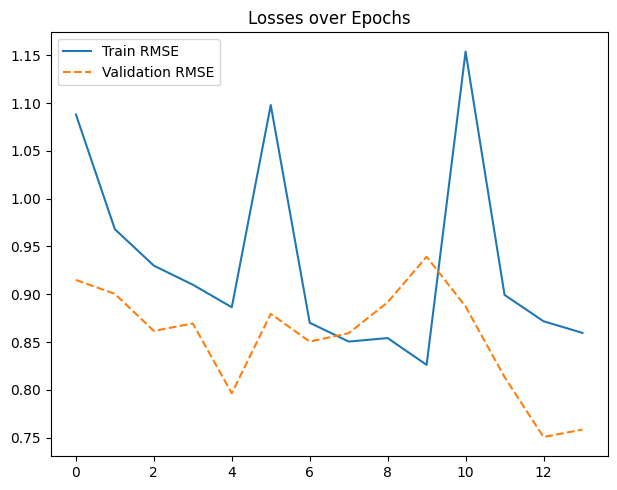

In [19]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses_wording, label="Train RMSE")
plt.plot(val_losses_wording, label="Validation RMSE", linestyle='--')
plt.legend()
plt.title("Losses over Epochs")

plt.tight_layout()
plt.show()

I want to plot final metrics on each fold

In [21]:
mean_rmse_train = [(c + w) / 2 for c, w in zip(train_losses_content, train_losses_wording)]
mean_rmse_valid = [(c + w) / 2 for c, w in zip(val_losses_content, val_losses_wording)]

folds = list(range(1, len(mean_rmse_train) + 1))
plt.figure(figsize=(10, 6))
plt.plot(folds, mean_rmse_train, '-o', label='Mean RMSE Train', color='green')
plt.plot(folds, mean_rmse_valid, '--o', label='Mean RMSE Valid', color='blue', linestyle='dashed')

plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.title('RMSE across Folds')
plt.xticks(folds)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Submission to Kaggle